Universidad de Costa Rica  <br>
CI-0148 Aprendizaje Máquina <br>
Período: 2022-I <br>
Docente: Pablo Sauma Chacón <br>
Estudiantes: 

- Jose Pablo Mora Villalobos. B85326 
- Juan José Valverde Campos. B47200 
***

# Laboratorio 6

Objetivo:  Familiarizar al estudiante con la creación y el uso de redes neuronales utilizando la biblioteca Torch. Así como la construcción de redes neuronales sofisticadas, como es el caso de redes generativas adversarias/antagónica.

[Descripción del laboratorio](https://docs.google.com/document/d/14Tv-fSLC92p4ukdme3r6xcJl7CwyM2LUU0Mw7YQwFrU/edit)

# Segmento para correr desde google colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importación de Librerías

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch as pt 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision 
import random
import time
import os

# Carga de Datos


In [ ]:
NUMERO = 0
train = torchvision.datasets.MNIST(".", download=True)
x = train.data.float()
x = x.unsqueeze(1)
y = train.targets
# Se conviert los valores en 1, si el target es igual a 0
true = y == NUMERO
x_true = x[true]
x_false = x[~true]
x_true.size()
x_false.size()

# Visualización de pruebas (Números)

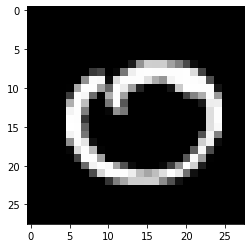

In [ ]:
from PIL import Image

def plot_image(img,save=False,name=None,show = True):
  cmap = 'gray' if img.shape[0]==1 else None
  data = (img.detach()*(255  if img.max()<=1 else 1)).permute((1,2,0)).numpy().astype(np.uint8)
  plt.figure()
  plt.imshow(data.squeeze(),cmap=cmap)
  if show:
    plt.show()
  if save:
    if img.shape[0]==1:
      plt.imsave(name, data.squeeze(), cmap=cmap)
    else:
      plt.imsave(name, data, cmap=cmap)
  plt.close()
  return Image.fromarray(data.squeeze())
a = plot_image(x_true[random.randint(0,x_true.shape[0])],save=False,name=None)


# Implementación de datos como batches

In [ ]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        super(MyDataset, self).__init__()
        assert x.shape[0] == y.shape[0] # assuming shape[0] = dataset size
        self.x = x
        self.y = y

    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]


# Implementación de Clase Clasificador

In [ ]:

class Classifier(pt.nn.Module):
  def __init__(self):
    super().__init__()
		# 1 x 28 x 28 
    self.fc1 = pt.nn.Conv2d(1, 3, (5,5),padding= "same")
    self.act1 = pt.nn.LeakyReLU()
    self.pool1 = pt.nn.MaxPool2d(2)
    # 3 x 14 x 14 
    self.fc2 = pt.nn.Conv2d(3, 6, (5,5),padding= "same")
    self.act2 = pt.nn.LeakyReLU()
    self.pool2 = pt.nn.MaxPool2d(2)
    # 6 x 7 x 7
    self.fc3 = pt.nn.Conv2d(6, 9, (3,3),padding= 1)
    self.act3 = pt.nn.LeakyReLU()
    self.pool3 = pt.nn.AvgPool2d(2)
    # 9 X 3 X 3
    self.fc4 = pt.nn.Linear( 81, 1)
    self.act4 = pt.nn.Tanh()        #cambio de sigmoid a tanh
    self.dropout = pt.nn.Dropout(0)
  
  def forward(self, x):
    h1 = self.pool1(self.act1(self.fc1(x)))
    h1 = self.dropout(h1)
    h2 = self.pool2(self.act2(self.fc2(h1)))
    h2 = self.dropout(h2)
    h3 = self.pool3(self.act3(self.fc3(h2)))
    h3 = self.dropout(h3)
    return self.act4(self.fc4(h3.view(h3.size(0), -1) ))

def get_sample(values, batch_size):
  indices = pt.tensor(random.sample(range(values.shape[0]), batch_size))
  indices = pt.tensor(indices)
  return values[indices]

# Implementación de entrenamiento de clasificador

In [ ]:
def train_classifier(opt, model, x_true, x_false, accuracy=None, max_iters=100, batch_size=1000, verb = 25, device = pt.cpu):
  if verb:
    print('classifier')
  # Se establecen los valores iniciales de entrenamiento
  loss_fn = pt.nn.MSELoss()	
  start = time.process_time()
  i = 0
  loss = 0
  accuracy = 1 if accuracy == None else accuracy # Sino se declara accurracy, se pone el mismo en 1
  # Se crea el batch a utiliza, tanto para aquellos batch que son verdadero y los otros que son falsos
  traindata = MyDataset(x_true, pt.ones(x_true.shape[0]))
  new_x_true = DataLoader(traindata,batch_size = batch_size, shuffle = True)
  traindata = MyDataset(x_false, pt.ones(x_false.shape[0]))
  new_x_false = DataLoader(traindata,batch_size = batch_size, shuffle = True)

  # Se declara el accuracy flag, para que se detenga el entrenamiento cuando se llegue a un accuracy maximo
  acc_flag = True 
  # Se detiene el entrenamiento si se llega al máximo de iteraciones o el accuracy flag se pone en falso (se llega al acurracy máximo)
  while i<max_iters and acc_flag:
    opt.zero_grad()			# Coloca los Δw en 0, para evitar que se afecte por iteraciones pasadas

    # Entrenamiento con valores verdaderos
    train_features, _  = next(iter(new_x_true)) # Solicita el batch de verdadedores
    y_pred_true = model(train_features).squeeze()		# Predice los valores del conjunto de entrenamiento    

    train_features, _  = next(iter(new_x_false)) # Solicita el batch de falsos
    y_pred_false = model(train_features).squeeze()		# Predice los valores del conjunto de entrenamiento    

    y_pred = pt.cat((y_pred_true,y_pred_false),0) # Concatena los y predict

    y_true = pt.cat((pt.ones(y_pred_true.shape[0]), pt.zeros(y_pred_true.shape[0])),0) # Concatena los y tanto de numeros verdadedor como los falsos

    acc = (y_pred_true > 0).sum().item() + (y_pred_false <= 0).sum().item() # Obtiene el accuracy final
    acc = acc/y_pred.shape[0]

    if accuracy<acc: # Si el accurracy sucede se detiene el entrenamiento 
      acc_flag = False
      y_pred_true.detach()
      y_pred_false.detach()
    else: # Caso contrario se actualiza los pesos
      loss = loss_fn(y_pred.to(device), y_true.to(device))	# Calcula la pérdida
      loss.backward(retain_graph=True)				# Calcula el backprogration (Δw) y acumula el error
      opt.step()				# Aplica los Δw acumulados y avanza un paso la iter. 

    if verb and (i+1)%verb==0: 
      print("Epoch: {}, Loss: {}, Acc: {}, Time: {:.2f}".format(i+1, loss, acc,time.process_time() - start))
    i+=1 # Se actualiza las iteraciones
  if verb and not acc_flag:
    print("Epoch: {}, Loss: {}, Acc: {}, Time: {:.2f}".format(i+1, loss, acc,time.process_time() - start))
  # Se guarda el modelo
  pt.save({ 
    'epoch': i,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': opt.state_dict(),
    'loss': acc
    }, "new_classifier")
  return acc


# Implementación de Clase Generador

In [ ]:
'''
Primera implementación de clase generador
'''
# class Generator(pt.nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.fc1 = pt.nn.ConvTranspose2d(1,1,5)
#     self.act1 = pt.nn.LeakyReLU()
#     self.fc1 = pt.nn.ConvTranspose2d(1,1,5,1)
#     self.act1 = pt.nn.LeakyReLU()
#     self.fc4 = pt.nn.Linear(324, 526)
#     self.act4 = pt.nn.Tanh()
#     self.fc5 = pt.nn.Linear(526, 784)
#     self.act5 = pt.nn.Tanh()
#     self.dropout = pt.nn.Dropout(0.5)
    

#   def forward(self, x):
#     r = self.act1(self.fc1(x.view((x.shape[0],1,10,10))))
#     r = self.act4(self.fc4(r.view(r.shape[0],324)))
#     r = self.dropout(r)
#     return ((self.act5(self.fc5(r))+1)*255/2)

'''
Segunda Implementación de clase generador
'''

class Generator(pt.nn.Module):
  def __init__(self):
    super().__init__()
    # Inicia con 100 datos aleatorios y pasa a 324 datos aleatorios
    self.l1 = pt.nn.Sequential(
        pt.nn.Linear(100, 324),
        pt.nn.Sigmoid()
    )
    # 324 = 9 x 6 x 6  y pasa a ser 6 x 12 x 12
    self.l2 = pt.nn.Sequential(
        pt.nn.ConvTranspose2d(9,6,3,padding=1),
        pt.nn.LeakyReLU(),
        pt.nn.Upsample(scale_factor=2,mode='bilinear')
    )
    # De ser  6 x 12 x 12 ahora es 3 x 28 x 28 
    self.l3 = pt.nn.Sequential(
        pt.nn.ConvTranspose2d(6,3,5,padding=1),
        pt.nn.LeakyReLU(),
        pt.nn.Upsample(scale_factor=2,mode='bilinear')
    )
    #  3 x 28 x 28 pasa a ser 1 x 28 x 28 = 784
    self.l4 = pt.nn.Sequential(
        pt.nn.ConvTranspose2d(3,1,3,padding=1),
        pt.nn.Sigmoid(),
    )
  def forward(self, x):
      x = self.l1(x)
      x = self.l2(x.view((x.shape[0],9,6,6)))
      x = self.l3(x)
      x = self.l4(x)
      # print(x.max(),x.min())
      return (x)*255

     

# Implementación de entrenamiento de generador

In [ ]:
def train_generator(opt, generator, classifier, accuracy=None, max_iters=100, batch_size=1000, verb = 25, device = pt.cpu,num_train=5000):
  if verb:
    print('generator')

  loss_fn = pt.nn.MSELoss()		# Función de error a utilizar
  start = time.process_time()
  i = 0
  loss = 0
  accuracy = 1 if accuracy == None else accuracy
  acc_flag = True
  while i<max_iters and acc_flag:
    opt.zero_grad()			# Coloca los Δw en 0
    x = generator(pt.rand(batch_size,100).to(device)).view((batch_size,1,28,28)).to(device)
    y_pred = classifier(x)	# Predice los valores del conjunto de entrenamiento

    acc = (y_pred > 0).sum().item()/y_pred.shape[0]

    if accuracy<acc:
      acc_flag = False
      y_pred.detach()
      break
    else:
      loss = loss_fn(y_pred.squeeze().to(device), pt.ones(batch_size).to(device))	# Calcula la pérdida
      loss.backward()				# Calcula el backprogration (Δw) y acumula el error
      opt.step()				    
      # Aplica los Δw acumulados y avanza un paso la iter.

    if verb and (i+1)%verb==0: 
      print("Epoch: {}, Loss: {}, Acc: {}, Time: {:.2f}".format(i+1, loss, acc,time.process_time() - start))
    i+=1
  if verb and not acc_flag:
    print("Epoch: {}, Loss: {}, Acc: {}, Time: {:.2f}".format(i+1, loss, acc,time.process_time() - start))
  pt.save({ 
    'epoch': i,
    'model_state_dict': generator.state_dict(),
    'optimizer_state_dict': opt.state_dict(),
    'loss': acc
    }, "new_generator")
  return acc

# Método de revisión para comprobar los sizes
Esta celda nos sirvió para comprobar cambios en las arquitecturas y poder depurar de forma rápida cuando queríamos obtener sizes correctos. 

In [ ]:
def test():  
  classifier = Classifier()		# Crea el modelo
  generator = Generator()
  optimizer_class = pt.optim.SGD(classifier.parameters(), lr=0.00001, momentum=0.001)		# Optimizador
  optimizer_gen = pt.optim.SGD(generator.parameters(), lr=0.01)		# Optimizador
  train_generator(optimizer_gen, generator, classifier,max_iters=10,batch_size=1000)
#test()

# Método para hacer reproducible la creación de la red neuronal

In [ ]:
def seed_everything(seed: int):
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    pt.manual_seed(seed)
    pt.cuda.manual_seed(seed)
    pt.backends.cudnn.deterministic = True
    pt.backends.cudnn.benchmark = True

# Implementación final de entrenamiento

In [ ]:
seed_everything(42)
device = pt.device('cuda' if pt.cuda.is_available() else 'cpu')
x_false, x_true = x_false.to(device), x_true.to(device)
plt.ioff()
def GAN():
  classifier = Classifier().to(device)		# Crea el modelo
  generator = Generator().to(device)
  optimizer_class = pt.optim.NAdam(classifier.parameters(), lr=1e-3, momentum_decay=1e-1)		# Optimizador
  optimizer_gen = pt.optim.NAdam(generator.parameters(), lr=1e-3, momentum_decay=1e-1)		# Optimizador

  samples = 3500
  images = x_false
  gif = []
  loss_class = []
  loss_gen = []
  start = time.process_time()
  for i in range(500):
    loss = train_classifier(optimizer_class, classifier, x_true, images.to(device), 
                            accuracy=0.99, max_iters=100, batch_size=samples, verb = None, device=device)
    loss2 = train_generator(optimizer_gen, generator, classifier,accuracy=0.99, 
                            max_iters=100,batch_size=samples, verb = None, device=device,num_train = x_true.shape[0])
    
    images = generator(pt.rand(samples,100).to(device)).detach()
    images = images.view((samples,1,28,28)).cpu()
    gif.append(plot_image(images[random.randint(0,images.shape[0]-1)],save=False,show=False))
    loss_class.append(loss)
    loss_gen.append(loss2)
    if (i+1) % 50 == 0:
      print('GAN gen: {}, Time: {:.2f}'.format(i+1,time.process_time() - start))
      gif[0].save('number.gif',save_all=True, append_images=gif[1:], loop=0, duration=200)
      fig=plt.figure()
      plt.plot(loss_class, label='Class')
      plt.plot(loss_gen, label='Gen')
      plt.legend()
      plt.ioff()
      plt.savefig('grafico.png')
      plt.cla()
      plt.close(fig)

GAN()

GAN gen: 50, Time: 56.25
GAN gen: 100, Time: 125.29
GAN gen: 150, Time: 165.78
GAN gen: 200, Time: 328.12
GAN gen: 250, Time: 503.07
GAN gen: 300, Time: 692.97
GAN gen: 350, Time: 883.99
GAN gen: 400, Time: 1074.95
GAN gen: 450, Time: 1265.15
GAN gen: 500, Time: 1456.17


## Resultados

Para crear la arquitectura del clasificador solo se intentó disminuir la dimensionalidad de las imágenes. La red no cambió mucho desde que se creó. Se utilizaron capas convolucionales y de salida una capa densa con función `tahn()` de salida. La red generadora sí pasó por varias arquitecturas. Primero se utilizó una red con capas densas pero la red aprendía. La segunda arquitectura involucraba capas convolucionales transversales (*traversal convolution*). En este caso se consiguieron mejores resultados y varios números convergieron. Por último se revisó la función de `Upsample()` para ver el efecto que tenía sobre la red. En general los resultados fueron parecidos a la red anterior, pero no tan buena. 

Una de las cosas que notamos es que las una de las redes tendía a ser muy buena y la otra no aprendía. Las formas que utilizamos para tratar de evitar esto fue cambiar los valores de *learning rate* y *decay* en los optimizadores. Un *learning rate* bajo hacía que las redes tardaran mucho entrenándose y no mejoraban demasiado y un *learning rate* alto hacía que una redes fuera demasiado buena en comparación a la otra. El valor que encontramos que dio los mejores resultados fue de 1e-3 para las dos redes. 

Un ejemplo de imágenes generadas con esta red GAN es:
![number gif](images/number.gif)

En el gif se observa que la imagen converja al valor de 0 en algunas iteraciones, pero mientras más se entrena más desaparece el valor. Esto puede ser ocasionado por un *overfitting* que hace que la red no logre aprender más y las imágenes no sean buenas.

